Clone Repository

In [ ]:
! git clone https://github.com/pijush2022/Lane_detection.git

## Install the Requirements

- Install all the python dependencies
- After Installing dependencies, Restart the runtime. If you do not restart the runtime, the python will throw "module not found error"

In [ ]:
!pip install -r road-detection/TwinLiteNet/requirements.txt

## Copy Dataset from Repository

- Our repository contains dataset.zip in datasets folder in the repository. copy that zip file to root

In [ ]:
!cp road-detection/datasets/dataset.zip ./

## Unzip the file

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/test/
   creating: dataset/test/images/
  inflating: dataset/test/images/road_image_160.png  
  inflating: dataset/test/images/road_image_161.png  
  inflating: dataset/test/images/road_image_162.png  
  inflating: dataset/test/images/road_image_163.png  
  inflating: dataset/test/images/road_image_164.png  
  inflating: dataset/test/images/road_image_165.png  
  inflating: dataset/test/images/road_image_166.png  
  inflating: dataset/test/images/road_image_167.png  
  inflating: dataset/test/images/road_image_168.png  
  inflating: dataset/test/images/road_image_169.png  
  inflating: dataset/test/images/road_image_170.png  
  inflating: dataset/test/images/road_image_171.png  
  inflating: dataset/test/images/road_image_172.png  
  inflating: dataset/test/images/road_image_173.png  
  inflating: dataset/test/images/road_image_174.png  
  inflating: dataset/test/images/road_image_175.png  
  inflating: dataset/test/images/road_image_176.png  

## Import the all the required libraries

In [ ]:
import torch
import cv2
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import os
import random
import math
from matplotlib import pyplot as plt
import torch.nn as nn

## Image transformation functions

- By paper author

In [ ]:
def augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """change color hue, saturation, value"""
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [ ]:
def random_perspective(combination,  degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    """combination of img transform"""
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]
    img, gray, line = combination
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpPerspective(gray, M, dsize=(width, height), borderValue=0)
            line = cv2.warpPerspective(line, M, dsize=(width, height), borderValue=0)
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))
            gray = cv2.warpAffine(gray, M[:2], dsize=(width, height), borderValue=0)
            line = cv2.warpAffine(line, M[:2], dsize=(width, height), borderValue=0)



    combination = (img, gray, line)
    return combination

## Custom Dataset Class

- This custom dataset class is based on the dataset class written by the author but with slight modifications like path. we have adjusted the path according to the google colab.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, transform=None, valid=False, test=False):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        :param transform: Type of transformation. SEe Transforms.py for supported transformations
        '''

        self.transform = transform
        self.Tensor = transforms.ToTensor()
        self.valid=valid
        if valid:
            self.root='dataset/validation/images'
            self.names=os.listdir(self.root)
        elif test:
            self.root='dataset/test/images'
            self.names=os.listdir(self.root)
        else:
            self.root='dataset/train/images/'
            self.names=os.listdir(self.root)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        W_=640
        H_=360
        image_name=os.path.join(self.root,self.names[idx])

        image = cv2.imread(image_name)
        original_image = cv2.imread(image_name)
        label1 = cv2.imread(image_name.replace("images","segments").replace("jpg","png"), 0)
        label2 = cv2.imread(image_name.replace("images","lane").replace("jpg","png"), 0)
        if not self.valid:
            if random.random()<0.5:
                combination = (image, label1, label2)
                (image, label1, label2)= random_perspective(
                    combination=combination,
                    degrees=10,
                    translate=0.1,
                    scale=0.25,
                    shear=0.0
                )
            if random.random()<0.5:
                augment_hsv(image)
            if random.random() < 0.5:
                image = np.fliplr(image)
                label1 = np.fliplr(label1)
                label2 = np.fliplr(label2)

        label1 = cv2.resize(label1, (W_, H_))
        label2 = cv2.resize(label2, (W_, H_))
        image = cv2.resize(image, (W_, H_))

        _,seg_b1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY_INV)
        _,seg_b2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY_INV)
        _,seg1 = cv2.threshold(label1,1,255,cv2.THRESH_BINARY)
        _,seg2 = cv2.threshold(label2,1,255,cv2.THRESH_BINARY)

        seg1 = self.Tensor(seg1)
        seg2 = self.Tensor(seg2)
        seg_b1 = self.Tensor(seg_b1)
        seg_b2 = self.Tensor(seg_b2)
        seg_da = torch.stack((seg_b1[0], seg1[0]),0)
        seg_ll = torch.stack((seg_b2[0], seg2[0]),0)
        image = image[:, :, ::-1].transpose(2, 0, 1)
        image = np.ascontiguousarray(image)

        return original_image, image_name,torch.from_numpy(image),(seg_da,seg_ll)

## Intialize a dataloader

- Intialize a dataloader with batch size 8

- Intialize train, test, validation datasets.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(MyDataset(), batch_size = 8, shuffle = True)
test_dataloader = DataLoader(MyDataset(test=True), batch_size = 8, shuffle = True)
val_dataloader = DataLoader(MyDataset(valid=True), batch_size = 8, shuffle = True)

## Display images

- Show first sample of each mini-batch with size 8

dataset/train/images/road_image_61.png
dataset/train/images/road_image_47.png
dataset/train/images/road_image_42.png
dataset/train/images/road_image_0.png
dataset/train/images/road_image_35.png
dataset/train/images/road_image_18.png
dataset/train/images/road_image_81.png
dataset/train/images/road_image_126.png
dataset/train/images/road_image_141.png
dataset/train/images/road_image_123.png
dataset/train/images/road_image_2.png
dataset/train/images/road_image_127.png
dataset/train/images/road_image_5.png
dataset/train/images/road_image_40.png
dataset/train/images/road_image_140.png
dataset/train/images/road_image_155.png
dataset/train/images/road_image_104.png
dataset/train/images/road_image_64.png
dataset/train/images/road_image_157.png
dataset/train/images/road_image_145.png


<Figure size 10000x10000 with 0 Axes>

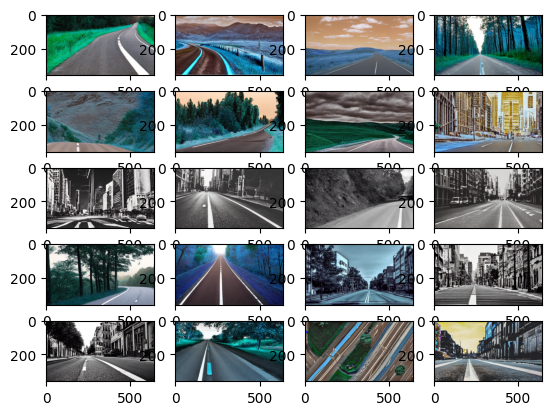

In [ ]:
# Printing the first sample of the each minibatch of size 8

plt.figure(figsize = (100, 100))

f, axarr = plt.subplots(5, 4)
i = 0
j = 0

for batch in train_dataloader:
  original_image, image_name, input, target = batch
  print(image_name[0])
  axarr[i, j].imshow(original_image[0])
  j += 1
  if j%4 == 0:
    i += 1
    j = 0

plt.show()

## Copy the required files from the repository to Root

In [ ]:
# Copy pretrained model from repository to root
!cp road-detection/TwinLiteNet/pretrained/best.pth ./

# Copy pytorch Neural Net from repo to root
!cp road-detection/TwinLiteNet/model/TwinLite.py ./

# Copy Loss function pytorch code from repo to root
!cp road-detection/TwinLiteNet/loss.py ./

# Copy all reqired constants from repo to root
!cp road-detection/TwinLiteNet/const.py ./

# Copy all val.py from repo to root
!cp road-detection/TwinLiteNet/val.py ./

## Load the pretrained model

In [ ]:
import TwinLite as net


model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('best.pth'))


<All keys matched successfully>

## Intialize loss and optimizer.

- This is based on the original code from paper author

In [ ]:
from tqdm import tqdm
from loss import TotalLoss

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

criteria = TotalLoss()

In [ ]:
args = dict()

args["lr"] = lr
args["max_epochs"] = 30
args["onGPU"] = True

In [ ]:
args

{'lr': 7.81e-06, 'max_epochs': 30, 'onGPU': True}

## Intialize Polynomial Learning Rate Scheduler

- By Paper Author

In [ ]:
def poly_lr_scheduler(args, optimizer, epoch, power=2):
    lr = round(args["lr"] * (1 - epoch / args["max_epochs"]) ** power, 8)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

## Write a trainer function for each epoch

- By Paper Author

In [ ]:
def train(args, train_loader, model, criterion, optimizer, epoch):
    model.train()

    total_batches = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(pbar, total=total_batches, bar_format='{l_bar}{bar:10}{r_bar}')
    j = 0
    avg_train_loss = 0
    for i, (_, _, input, target) in pbar:
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)

        # target=target.cuda()
        optimizer.zero_grad()

        focal_loss,tversky_loss,loss = criterion(output,target)
        avg_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(('%13s' * 1 + '%13.4g' * 3) %
                                     (f'{epoch}/{args["max_epochs"] - 1}', tversky_loss, focal_loss, loss.item()))
        j += 1
    return avg_train_loss/j, loss.item()

## Train the model with custom data and also print the loss

- This loss is based on the paper

In [ ]:
print("------------------------------------------")
training_loss_last_batch = []
validation_loss_last_batch = []
for epoch in range(0, args["max_epochs"]):
    print(f"Epoch: {epoch + 1}/{args['max_epochs']}")
    poly_lr_scheduler(args, optimizer, epoch)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Learning rate: " +  str(lr))
    print()

    # train for one epoch
    model.train()
    avg_train_loss, loss_for_last_batch_train = train( args, train_dataloader, model, criteria, optimizer, epoch)
    model.eval()

    avg_val_loss = 0
    i = 0
    for batch in val_dataloader:
        _, _, input, target = batch
        if args["onGPU"] == True:
            input = input.cuda().float() / 255.0
        output = model(input)
        focal_loss, tversky_loss, loss = criteria(output, target)
        avg_val_loss += loss.item()
        i += 1

    print()
    print(f"Average Training Loss: {avg_train_loss}")
    print(f"Average Validation Loss: {avg_val_loss/i}")
    print()
    print(f"Training loss for last batch: {loss_for_last_batch_train}")
    print(f"Validation loss for last batch: {loss.item()}")
    print("------------------------------------------")
    training_loss_last_batch.append(loss_for_last_batch_train)
    validation_loss_last_batch.append(loss.item())


------------------------------------------
Epoch: 1/30
Learning rate: 7.81e-06



         0/29       0.0602      0.02575      0.08595: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]



Average Training Loss: 0.16505988352000714
Average Validation Loss: 0.17195375760396323

Training loss for last batch: 0.08595025539398193
Validation loss for last batch: 0.16030383110046387
------------------------------------------
Epoch: 2/30
Learning rate: 7.3e-06



         1/29       0.1232      0.03386       0.1571: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]



Average Training Loss: 0.15430011823773385
Average Validation Loss: 0.1856925586859385

Training loss for last batch: 0.15708911418914795
Validation loss for last batch: 0.2438523769378662
------------------------------------------
Epoch: 3/30
Learning rate: 6.8e-06



         2/29      0.08851      0.05611       0.1446: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]



Average Training Loss: 0.14889373779296874
Average Validation Loss: 0.18966013938188553

Training loss for last batch: 0.14462456107139587
Validation loss for last batch: 0.29650747776031494
------------------------------------------
Epoch: 4/30
Learning rate: 6.33e-06



         3/29      0.08721      0.03725       0.1245: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]



Average Training Loss: 0.15603391714394094
Average Validation Loss: 0.16158105432987213

Training loss for last batch: 0.12445536255836487
Validation loss for last batch: 0.13932450115680695
------------------------------------------
Epoch: 5/30
Learning rate: 5.87e-06



         4/29      0.08816      0.06617       0.1543: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.15671782456338407
Average Validation Loss: 0.1615806519985199

Training loss for last batch: 0.15432827174663544
Validation loss for last batch: 0.1095014363527298
------------------------------------------
Epoch: 6/30
Learning rate: 5.42e-06



         5/29      0.04828       0.0326      0.08088: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]



Average Training Loss: 0.15002040676772593
Average Validation Loss: 0.16637644420067468

Training loss for last batch: 0.08087820559740067
Validation loss for last batch: 0.1705670952796936
------------------------------------------
Epoch: 7/30
Learning rate: 5e-06



         6/29       0.1133      0.07253       0.1859: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.14174044989049434
Average Validation Loss: 0.17074661453564963

Training loss for last batch: 0.18586532771587372
Validation loss for last batch: 0.1687607765197754
------------------------------------------
Epoch: 8/30
Learning rate: 4.59e-06



         7/29      0.03796      0.02702      0.06498: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.1428067024797201
Average Validation Loss: 0.1614452451467514

Training loss for last batch: 0.0649801641702652
Validation loss for last batch: 0.09930221736431122
------------------------------------------
Epoch: 9/30
Learning rate: 4.2e-06



         8/29       0.1223      0.04671       0.1691: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.14781550765037538
Average Validation Loss: 0.17173205812772116

Training loss for last batch: 0.169050931930542
Validation loss for last batch: 0.16327445209026337
------------------------------------------
Epoch: 10/30
Learning rate: 3.83e-06



         9/29      0.05029      0.03684      0.08712: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.14172310307621955
Average Validation Loss: 0.15306390076875687

Training loss for last batch: 0.08712434768676758
Validation loss for last batch: 0.07803253084421158
------------------------------------------
Epoch: 11/30
Learning rate: 3.47e-06



        10/29       0.1494      0.06082       0.2102: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.15095466040074826
Average Validation Loss: 0.1707787166039149

Training loss for last batch: 0.21020814776420593
Validation loss for last batch: 0.1891394555568695
------------------------------------------
Epoch: 12/30
Learning rate: 3.13e-06



        11/29       0.1207      0.03342       0.1542: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.14152251407504082
Average Validation Loss: 0.173787588874499

Training loss for last batch: 0.15415552258491516
Validation loss for last batch: 0.2010851949453354
------------------------------------------
Epoch: 13/30
Learning rate: 2.81e-06



        12/29       0.1169      0.07269       0.1896: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.14255969747900962
Average Validation Loss: 0.17253004014492035

Training loss for last batch: 0.1895551085472107
Validation loss for last batch: 0.1678355634212494
------------------------------------------
Epoch: 14/30
Learning rate: 2.51e-06



        13/29      0.08675      0.06069       0.1474: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s]



Average Training Loss: 0.17735095471143722
Average Validation Loss: 0.1975652277469635

Training loss for last batch: 0.14743605256080627
Validation loss for last batch: 0.2734057307243347
------------------------------------------
Epoch: 15/30
Learning rate: 2.22e-06



        14/29      0.08005      0.04723       0.1273: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.16895082630217076
Average Validation Loss: 0.1647037168343862

Training loss for last batch: 0.12727907299995422
Validation loss for last batch: 0.14545108377933502
------------------------------------------
Epoch: 16/30
Learning rate: 1.95e-06



        15/29       0.1565       0.1308       0.2873: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]



Average Training Loss: 0.15768137760460377
Average Validation Loss: 0.17689465483029684

Training loss for last batch: 0.2873290479183197
Validation loss for last batch: 0.20976318418979645
------------------------------------------
Epoch: 17/30
Learning rate: 1.7e-06



        16/29      0.07189      0.04295       0.1148: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]



Average Training Loss: 0.15491888858377934
Average Validation Loss: 0.19553624590237936

Training loss for last batch: 0.1148422360420227
Validation loss for last batch: 0.2579432725906372
------------------------------------------
Epoch: 18/30
Learning rate: 1.47e-06



        17/29      0.06219      0.04577        0.108: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]



Average Training Loss: 0.14537633284926416
Average Validation Loss: 0.1745979239543279

Training loss for last batch: 0.10796540975570679
Validation loss for last batch: 0.18563099205493927
------------------------------------------
Epoch: 19/30
Learning rate: 1.25e-06



        18/29       0.1354       0.1263       0.2617: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.1669111404567957
Average Validation Loss: 0.1655223270257314

Training loss for last batch: 0.2616710662841797
Validation loss for last batch: 0.16377690434455872
------------------------------------------
Epoch: 20/30
Learning rate: 1.05e-06



        19/29       0.1042      0.04697       0.1512: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]



Average Training Loss: 0.14424048736691475
Average Validation Loss: 0.17499233782291412

Training loss for last batch: 0.15116432309150696
Validation loss for last batch: 0.1368386298418045
------------------------------------------
Epoch: 21/30
Learning rate: 8.7e-07



        20/29      0.05865      0.03851      0.09716: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]



Average Training Loss: 0.14654355086386203
Average Validation Loss: 0.1619397054115931

Training loss for last batch: 0.09716343134641647
Validation loss for last batch: 0.1206551045179367
------------------------------------------
Epoch: 22/30
Learning rate: 7e-07



        21/29      0.07364      0.06382       0.1375: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]



Average Training Loss: 0.142802831530571
Average Validation Loss: 0.17672798037528992

Training loss for last batch: 0.1374579668045044
Validation loss for last batch: 0.21600624918937683
------------------------------------------
Epoch: 23/30
Learning rate: 5.6e-07



        22/29      0.04075      0.03252      0.07327: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]



Average Training Loss: 0.14292535781860352
Average Validation Loss: 0.18264439702033997

Training loss for last batch: 0.07327256351709366
Validation loss for last batch: 0.09688904881477356
------------------------------------------
Epoch: 24/30
Learning rate: 4.3e-07



        23/29      0.07689      0.06706       0.1439: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]



Average Training Loss: 0.1439155165106058
Average Validation Loss: 0.17290428280830383

Training loss for last batch: 0.143948033452034
Validation loss for last batch: 0.19821098446846008
------------------------------------------
Epoch: 25/30
Learning rate: 3.1e-07



        24/29      0.09233      0.05896       0.1513: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.15240162312984468
Average Validation Loss: 0.19096715251604715

Training loss for last batch: 0.15129002928733826
Validation loss for last batch: 0.257914662361145
------------------------------------------
Epoch: 26/30
Learning rate: 2.2e-07



        25/29      0.08906      0.04546       0.1345: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s]



Average Training Loss: 0.14428124949336052
Average Validation Loss: 0.2000656525293986

Training loss for last batch: 0.13452312350273132
Validation loss for last batch: 0.2426987588405609
------------------------------------------
Epoch: 27/30
Learning rate: 1.4e-07



        26/29       0.1107      0.08925       0.1999: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]



Average Training Loss: 0.14430663473904132
Average Validation Loss: 0.17565027872721353

Training loss for last batch: 0.19992004334926605
Validation loss for last batch: 0.16456827521324158
------------------------------------------
Epoch: 28/30
Learning rate: 8e-08



        27/29      0.08643      0.07602       0.1625: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]



Average Training Loss: 0.16076706908643246
Average Validation Loss: 0.15946287165085474

Training loss for last batch: 0.16245479881763458
Validation loss for last batch: 0.08424156159162521
------------------------------------------
Epoch: 29/30
Learning rate: 3e-08



        28/29      0.05481      0.05972       0.1145: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]



Average Training Loss: 0.15822646245360375
Average Validation Loss: 0.19661131501197815

Training loss for last batch: 0.11452271789312363
Validation loss for last batch: 0.26914864778518677
------------------------------------------
Epoch: 30/30
Learning rate: 1e-08



        29/29      0.06289      0.04731       0.1102: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]



Average Training Loss: 0.13972755856812
Average Validation Loss: 0.18667576710383096

Training loss for last batch: 0.11020036041736603
Validation loss for last batch: 0.25874409079551697
------------------------------------------


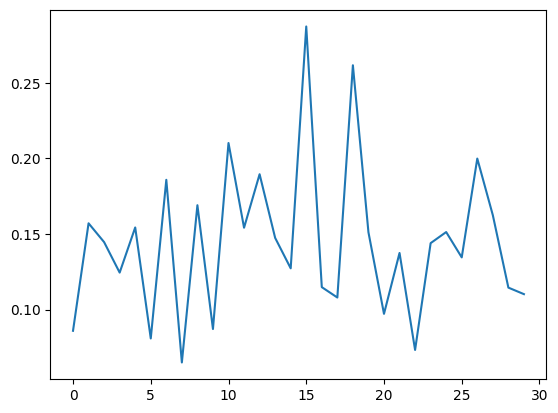

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x = list(range(len(training_loss_last_batch)))
y = training_loss_last_batch

plt.plot(x, y)

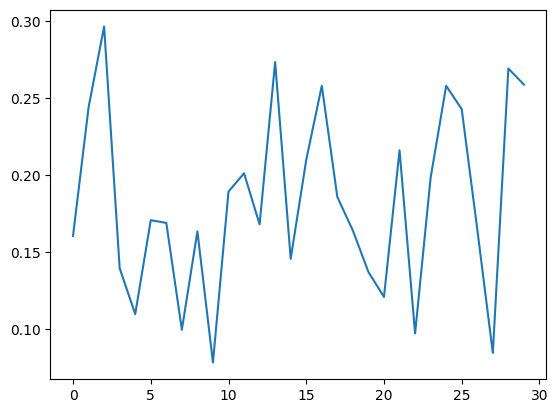

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x = list(range(len(validation_loss_last_batch)))
y = validation_loss_last_batch

plt.plot(x, y)

## Calculating loss on Test data

In [ ]:
avg_test_loss = 0
i = 0
for batch in test_dataloader:
    _, _, input, target = batch
    if args["onGPU"] == True:
        input = input.cuda().float() / 255.0
    output = model(input)
    focal_loss, tversky_loss, loss = criteria(output, target)
    avg_test_loss += loss.item()
    i += 1

print("------------------------------------------")
print(f"Average Testing Loss: {avg_test_loss/i}")
print(f"Testing loss for last batch: {loss.item()}")
print("------------------------------------------")

------------------------------------------
Average Testing Loss: 0.23437678317228952
Testing loss for last batch: 0.19679684937000275
------------------------------------------


# Defining functions to calculate Pixel Accuracy and Intersection of Union

- by paper author

In [ ]:
class SegmentationMetric(object):
    '''
    imgLabel [batch_size, height(144), width(256)]
    confusionMatrix [[0(TN),1(FP)],
                     [2(FN),3(TP)]]
    '''
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)

    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        # acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc


    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / (self.confusionMatrix.sum(axis=0) + 1e-12)
        return classAcc

    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc)
        return meanAcc

    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        IoU[np.isnan(IoU)] = 0
        mIoU = np.nanmean(IoU)
        return mIoU

    def IntersectionOverUnion(self):
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        IoU[np.isnan(IoU)] = 0
        return IoU[1]

    def genConfusionMatrix(self, imgPredict, imgLabel):
        # remove classes from unlabeled pixels in gt image and predict
        # print(imgLabel.shape)
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix

    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = np.sum(self.confusionMatrix, axis=1) / np.sum(self.confusionMatrix)
        iu = np.diag(self.confusionMatrix) / (
                np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) -
                np.diag(self.confusionMatrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU


    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)

    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [ ]:
@torch.no_grad()
def val(val_loader, model):

    model.eval()


    DA=SegmentationMetric(2)
    LL=SegmentationMetric(2)

    da_acc_seg = AverageMeter()
    da_IoU_seg = AverageMeter()
    da_mIoU_seg = AverageMeter()

    ll_acc_seg = AverageMeter()
    ll_IoU_seg = AverageMeter()
    ll_mIoU_seg = AverageMeter()
    total_batches = len(val_loader)

    total_batches = len(val_loader)
    pbar = enumerate(val_loader)
    pbar = tqdm(pbar, total=total_batches)
    for i, (_, _,input, target) in pbar:
        input = input.cuda().float() / 255.0
            # target = target.cuda()

        input_var = input
        target_var = target

        # run the mdoel
        with torch.no_grad():
            output = model(input_var)

        out_da,out_ll=output
        target_da,target_ll=target

        _,da_predict=torch.max(out_da, 1)
        _,da_gt=torch.max(target_da, 1)

        _,ll_predict=torch.max(out_ll, 1)
        _,ll_gt=torch.max(target_ll, 1)
        DA.reset()
        DA.addBatch(da_predict.cpu(), da_gt.cpu())


        da_acc = DA.pixelAccuracy()
        da_IoU = DA.IntersectionOverUnion()
        da_mIoU = DA.meanIntersectionOverUnion()

        da_acc_seg.update(da_acc,input.size(0))
        da_IoU_seg.update(da_IoU,input.size(0))
        da_mIoU_seg.update(da_mIoU,input.size(0))


        LL.reset()
        LL.addBatch(ll_predict.cpu(), ll_gt.cpu())


        ll_acc = LL.pixelAccuracy()
        ll_IoU = LL.IntersectionOverUnion()
        ll_mIoU = LL.meanIntersectionOverUnion()

        ll_acc_seg.update(ll_acc,input.size(0))
        ll_IoU_seg.update(ll_IoU,input.size(0))
        ll_mIoU_seg.update(ll_mIoU,input.size(0))

    da_segment_result = (da_acc_seg.avg,da_IoU_seg.avg,da_mIoU_seg.avg)
    ll_segment_result = (ll_acc_seg.avg,ll_IoU_seg.avg,ll_mIoU_seg.avg)
    return da_segment_result,ll_segment_result

# Evaluating metrics

In [ ]:
model.eval()
example = torch.rand(1, 3, 360, 640).cuda()
model = torch.jit.trace(model, example)
da_segment_results,ll_segment_results = val(test_dataloader, model)

msg =  'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                    'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})'.format(
                        da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                        ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2])

100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


In [ ]:
print(msg)

Driving area Segment: Acc(0.963)    IOU (0.778)    mIOU(0.868)
Lane line Segment: Acc(0.984)    IOU (0.209)  mIOU(0.597)


# Metrics

- Evaluation metrics are pixel accuracy and IoU(Intersection over Union).
- We have achieved an accuracy of 96.3% for Driving area segment
- We have achieved an accuracy of 98.4% for Lane Line segment.


# Saving the model

In [ ]:
torch.save(model.state_dict(), "fine-tuned-model.pth")

In [ ]:
model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('fine-tuned-model.pth'))

<All keys matched successfully>

In [48]:
import torch
import numpy as np
import shutil
from tqdm.autonotebook import tqdm
import os
import os
import torch
import TwinLite as net


model = net.TwinLiteNet()
import cv2

def Run(model,img):
    img = cv2.resize(img, (640, 360))
    img_rs=img.copy()

    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img=torch.from_numpy(img)
    img = torch.unsqueeze(img, 0)  # add a batch dimension
    img=img.cuda().float() / 255.0
    img = img.cuda()
    with torch.no_grad():
        img_out = model(img)
    x0=img_out[0]
    x1=img_out[1]

    _,da_predict=torch.max(x0, 1)
    _,ll_predict=torch.max(x1, 1)

    DA = da_predict.byte().cpu().data.numpy()[0]*255
    LL = ll_predict.byte().cpu().data.numpy()[0]*255
    img_rs[DA>100]=[255,0,0]
    img_rs[LL>100]=[0,255,0]

    return img_rs


model = net.TwinLiteNet()
model = torch.nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('fine-tuned-model.pth'))
model.eval()

#img = cv2.imread("dataset/test/images/road_image_160.png")
img = cv2.imread("/content/unh.jpg")
img = Run(model, img)
cv2.imwrite("unh1.jpg", img)

True

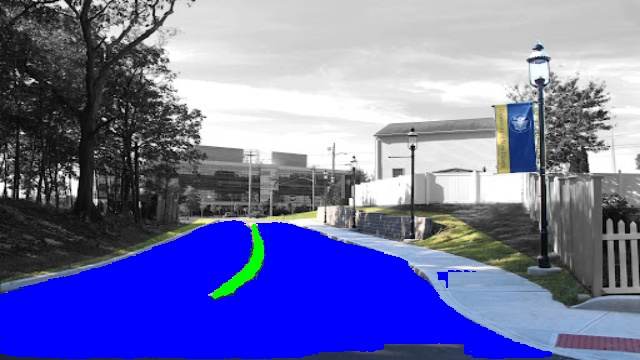

In [49]:
from PIL import Image


# Blue area is drivable area, green lines are lanes
Image.open("unh1.jpg")